Here is the first approach the the generalisation to 2 dimensional examples.

We consider Complex Ginzburg Landau, with additive noise.

The observation operator only observes the absolute value. 

We employ an ENKF

It is necessary to get enough observations

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.CGLE import *
from filters import resamplers
from filters.filter_2D import EnsembleKalmanFilter_2D
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

float64


Initialisation of a twin experiment. 

In [2]:
signal_params = ConfigDict(CGLE_params)
ensemble_params = ConfigDict(CGLE_params)
signal_params.update(E=1,S=3,noise_magnitude = 0.001,stochastic_advection_basis='sin_sin')
ensemble_params.update(E=32,S=3,noise_magnitude = 0.001,stochastic_advection_basis='sin_sin')
key = jax.random.PRNGKey(0)

Now we specify the models, by calling the class.

In [3]:
signal_model = CGLE_SETD_KT_CM_JAX(signal_params)
ensemble_model = CGLE_SETD_KT_CM_JAX(ensemble_params)

initial_signal = initial_condition(signal_model.xx,signal_model.yy,signal_params.E,signal_params.initial_condition)#initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.xx, ensemble_model.yy, ensemble_params.E, ensemble_params.initial_condition)

print(ensemble_model.params,ensemble_model.params.nt)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

E: 32
Forcing_basis_name: sin_sin
L: 100.0
Nt: 640
S: 3
alpha: 0.0
beta: 1.5
dt: 0.1
dx: 0.78125
equation_name: Complex Ginzburg-Landau
initial_condition: chebfun
method: Dealiased_SETDRK4_forced
noise_magnitude: 0.001
nt: 640
nx: 128
stochastic_advection_basis: sin_sin
tmax: 64.0
xmax: 50.0
xmin: -50.0
 640
multinomial, systematic, no_resampling, none, default


In [ ]:
observation_spatial_frequency = int(64)
#observation_locations = np.arange(signal_model.params.xmin,signal_model.params.xmax,observation_spatial_frequency,dtype=int)
observation_noise = 0.5
number_of_observations_time = int(ensemble_model.params.nt/32)
# Observe points every 4th grid cell in both directions
observation_locations = [(i, j) for i in range(0, 128, 8) for j in range(0, 128, 8)]

observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)
print(f"Observation temporal frequency: {observation_temporal_frequency}")
print(f"Observation spatial locations:{observation_locations}")
enkf = EnsembleKalmanFilter_2D(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    observation_locations = observation_locations,
    relaxation_factor = 0.05,# weights between forecast and analysis.
    inflation_factor = 1.00005,# highly sensitive manner of introducing spread
)
print(jnp.array(observation_locations).shape)

Observation temporal frequency: 1
Observation spatial locations:[(0, 0), (0, 8), (0, 16), (0, 24), (0, 32), (0, 40), (0, 48), (0, 56), (0, 64), (0, 72), (0, 80), (0, 88), (0, 96), (0, 104), (0, 112), (0, 120), (8, 0), (8, 8), (8, 16), (8, 24), (8, 32), (8, 40), (8, 48), (8, 56), (8, 64), (8, 72), (8, 80), (8, 88), (8, 96), (8, 104), (8, 112), (8, 120), (16, 0), (16, 8), (16, 16), (16, 24), (16, 32), (16, 40), (16, 48), (16, 56), (16, 64), (16, 72), (16, 80), (16, 88), (16, 96), (16, 104), (16, 112), (16, 120), (24, 0), (24, 8), (24, 16), (24, 24), (24, 32), (24, 40), (24, 48), (24, 56), (24, 64), (24, 72), (24, 80), (24, 88), (24, 96), (24, 104), (24, 112), (24, 120), (32, 0), (32, 8), (32, 16), (32, 24), (32, 32), (32, 40), (32, 48), (32, 56), (32, 64), (32, 72), (32, 80), (32, 88), (32, 96), (32, 104), (32, 112), (32, 120), (40, 0), (40, 8), (40, 16), (40, 24), (40, 32), (40, 40), (40, 48), (40, 56), (40, 64), (40, 72), (40, 80), (40, 88), (40, 96), (40, 104), (40, 112), (40, 120), (

To run the filter with all outputs, the input arrays need to have 3 dimensions.
They are (time, n_particles, space).

In [5]:
da_steps = number_of_observations_time
#print(initial_ensemble.shape, initial_signal.shape, da_steps)
initial_ensemble = initial_ensemble[None, ...] # adding the time dimension
initial_signal = initial_signal[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX
final, all = enkf.run(initial_ensemble, initial_signal, da_steps ,key) #the final input is scan length? 
final_noda, all_noda = enkf.run_no_da(initial_ensemble, initial_signal, da_steps ,key) #the final input is scan length?


(1, 1, 128, 128)
(3, 128, 128) (1, 3) (1, 3)
(1, 32, 128, 128)
(3, 128, 128) (32, 3) (32, 3)
(1, 1, 128, 128)
(3, 128, 128) (1, 3) (1, 3)
(1, 32, 128, 128)
(3, 128, 128) (32, 3) (32, 3)


In [6]:
print("final shapes:")
for i, arr in enumerate(final):
    print(f"final[{i}]:", arr.shape)

print("\nall shapes:")
for i, arr in enumerate(all):
    print(f"all[{i}]:", arr.shape)

final shapes:
final[0]: (1, 32, 128, 128)
final[1]: (1, 1, 128, 128)
final[2]: (2,)

all shapes:
all[0]: (640, 1, 32, 128, 128)
all[1]: (640, 1, 1, 128, 128)
all[2]: (640, 256)


In [7]:
print("\nFinal ensemble shape:", final)# force the computation of the model.CGLE 32x640x128x128 # 1min


Final ensemble shape: (Array([[[[0.5929851 +0.75528706j, 0.57770852+0.75748786j,
          0.53067475+0.76154648j, ..., 0.44795529+0.75898168j,
          0.52772439+0.76359291j, 0.57647317+0.75854487j],
         [0.57764855+0.75769286j, 0.60547816+0.74587431j,
          0.60318773+0.7383689j , ..., 0.32991331+0.71523578j,
          0.43650219+0.75994663j, 0.52069458+0.76706965j],
         [0.52961606+0.76232318j, 0.60239037+0.73893383j,
          0.64858363+0.7075763j , ..., 0.24101224+0.57959451j,
          0.33724809+0.70660586j, 0.43740716+0.75948268j],
         ...,
         [0.4453079 +0.75875904j, 0.3283581 +0.71327542j,
          0.24174261+0.57594429j, ..., 0.72628382+0.61693135j,
          0.66060648+0.68350004j, 0.56395308+0.73862126j],
         [0.52605374+0.76379062j, 0.4353299 +0.75924703j,
          0.3377943 +0.70479252j, ..., 0.66191358+0.68277882j,
          0.64400634+0.71139856j, 0.59818837+0.74175707j],
         [0.57584066+0.75865461j, 0.52026059+0.76678561j,
    

Put in the initial condition.

In [8]:
print(initial_ensemble.shape, initial_signal.shape)
answer = jnp.concatenate([initial_ensemble[jnp.newaxis,...],all[0]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member
print("answer shape:", answer.shape)
signal_answer = jnp.concatenate([initial_signal[jnp.newaxis,...],all[1]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member
print(signal_answer.shape,answer.shape)
noda_answer = jnp.concatenate([initial_ensemble[jnp.newaxis,...],all_noda[0]], axis=0)[:,0,...]  # Concatenate along the time dimension and take the first ensemble member


(1, 32, 128, 128) (1, 1, 128, 128)
answer shape: (641, 32, 128, 128)
(641, 1, 128, 128) (641, 32, 128, 128)


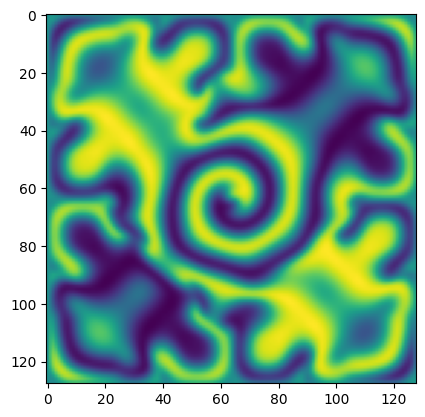

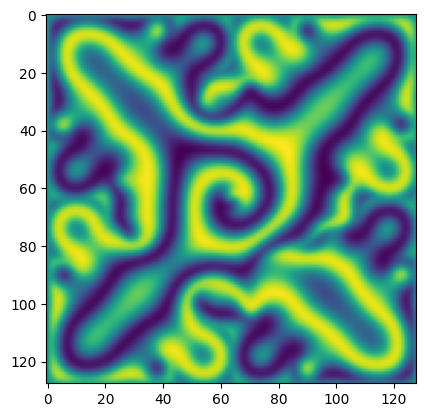

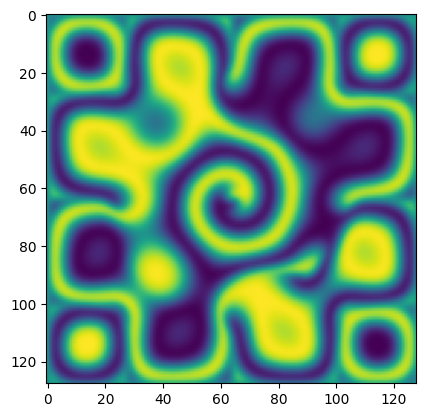

In [9]:
plt.imshow(answer[150, 9, :,:].real.T)
plt.show()
plt.imshow(signal_answer[150,0,:,:].real.T)
plt.show()
plt.imshow(noda_answer[150, 9, :,:].real.T)
plt.show()

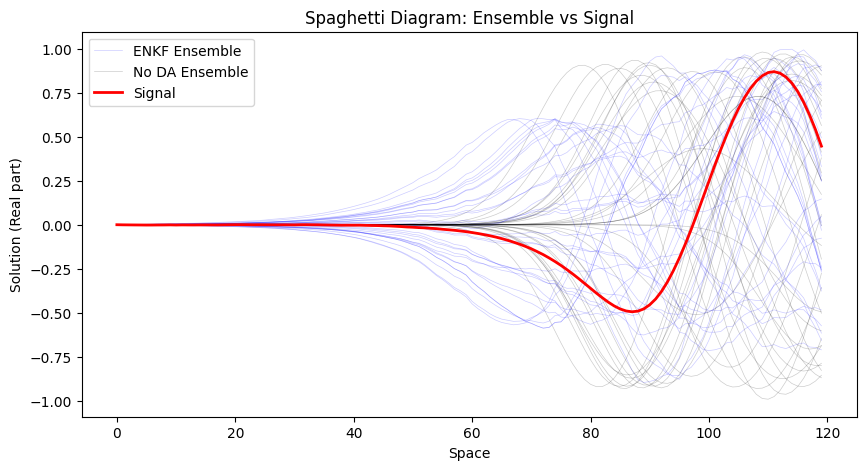

In [10]:
plt.figure(figsize=(10, 5))
# Plot all ensemble members (spaghetti)
k,l = 32,14
tmax = 120
for e in range(answer.shape[1]):
    plt.plot(answer[:tmax, e, k,l].real.T, color='b', alpha=0.2, linewidth=0.5)
    plt.plot(noda_answer[:tmax, e, k,l].imag.T, color='k', alpha=0.2, linewidth=0.5)
# Plot the signal
plt.plot(answer[:tmax, 0, k,l].real.T, color='b', alpha=0.2, linewidth=0.5,label='ENKF Ensemble')
plt.plot(noda_answer[:tmax, 0, k,l].imag.T, color='k', alpha=0.2, linewidth=0.5, label='No DA Ensemble')
plt.plot(signal_answer[:tmax,0,k,l].real.T, color='r', linewidth=2, label='Signal')
plt.xlabel('Space')
plt.ylabel('Solution (Real part)')
plt.title('Spaghetti Diagram: Ensemble vs Signal')
plt.legend()
plt.show()

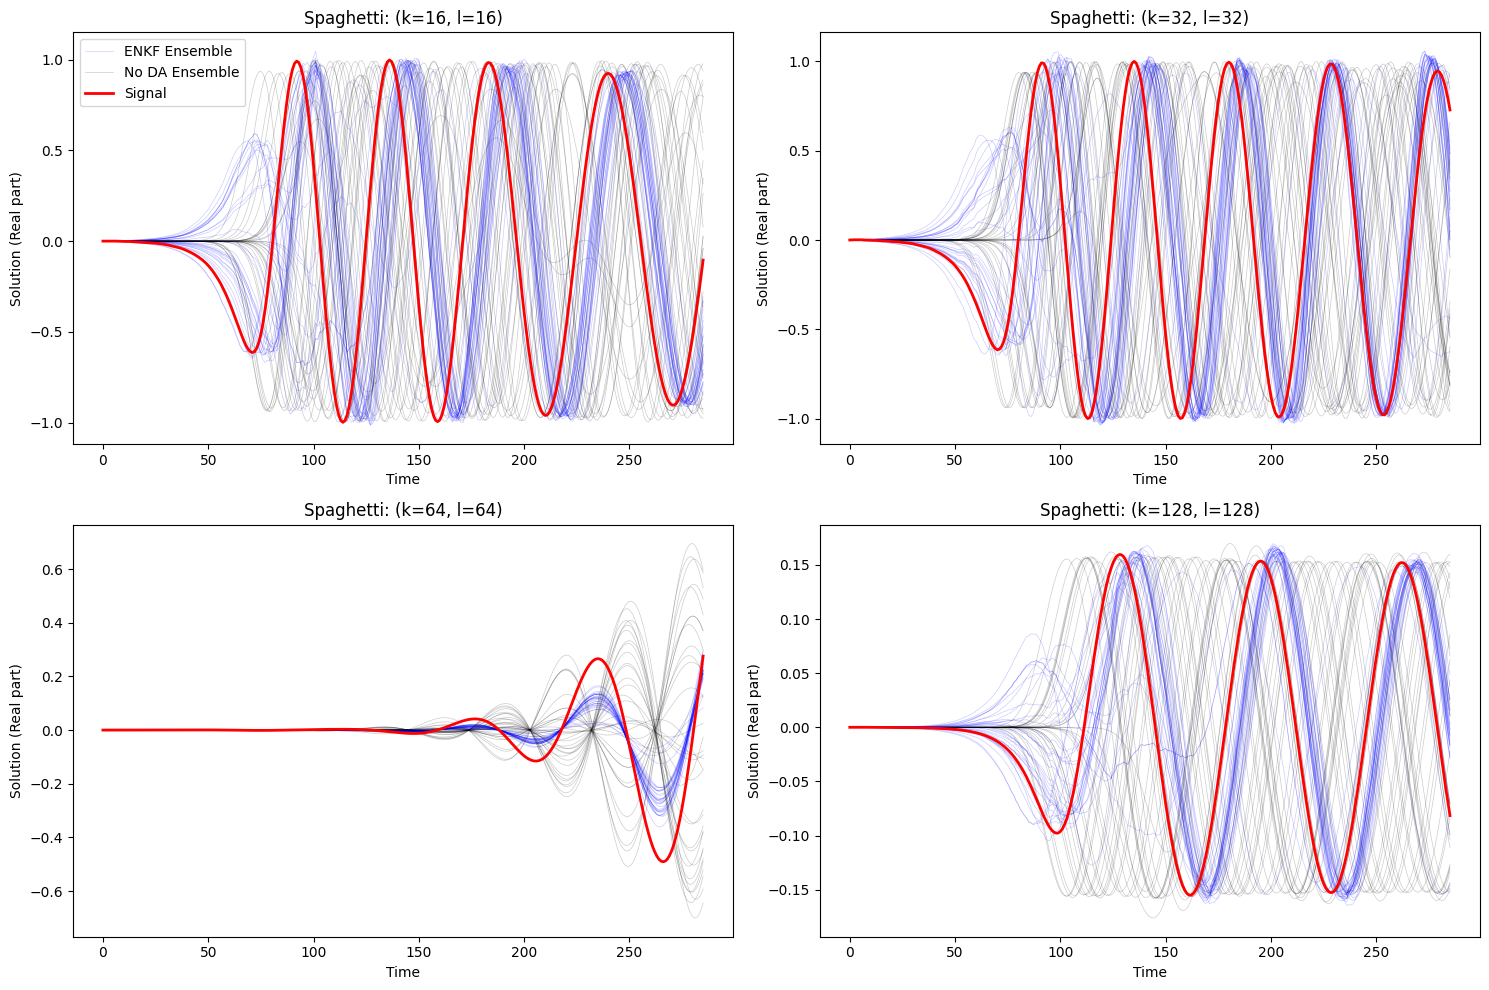

In [11]:
plt.figure(figsize=(15, 10))
points = [(16, 16), (32, 32), (64, 64), (128, 128)]  # example points, change as needed
tmax= 286
for idx, (k, l) in enumerate(points):
    plt.subplot(2, 2, idx + 1)
    for e in range(answer.shape[1]):
        plt.plot(answer[:tmax, e, k, l].real.T, color='b', alpha=0.2, linewidth=0.5)
        plt.plot(noda_answer[:tmax, e, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5)
    plt.plot(answer[:tmax, 0, k, l].real.T, color='b', alpha=0.2, linewidth=0.5, label='ENKF Ensemble')
    plt.plot(noda_answer[:tmax, 0, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5, label='No DA Ensemble')
    plt.plot(signal_answer[:tmax, 0, k, l].real.T, color='r', linewidth=2, label='Signal')
    plt.xlabel('Time')
    plt.ylabel('Solution (Real part)')
    plt.title(f'Spaghetti: (k={k}, l={l})')
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

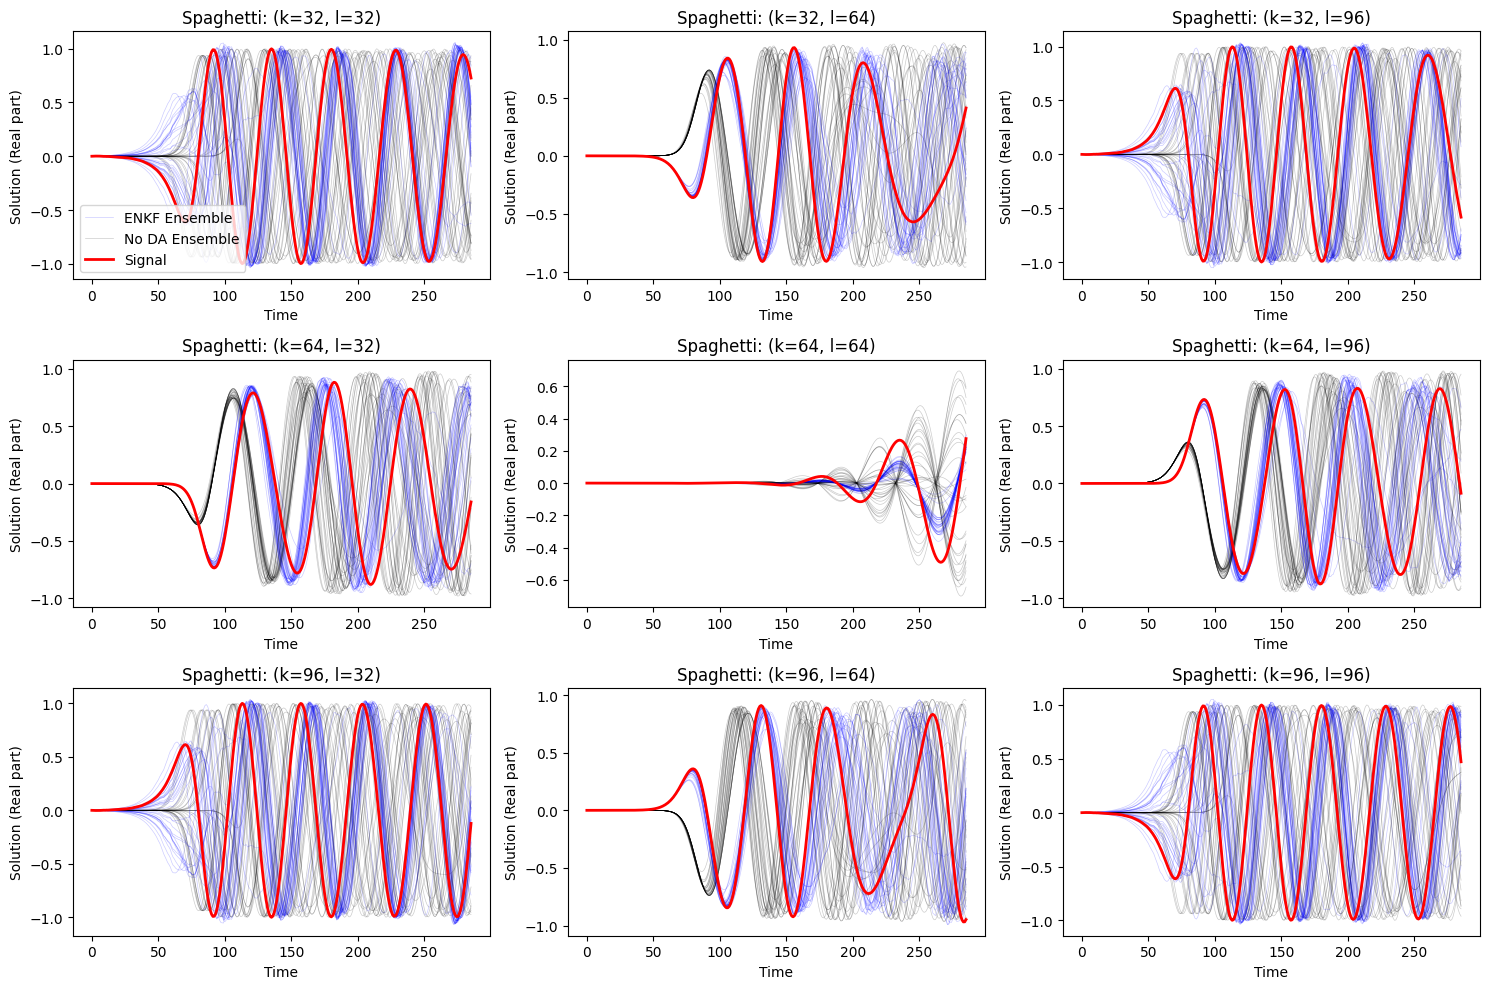

In [12]:
plt.figure(figsize=(15, 10))
points = [(32, 32), (32, 64), (32, 96), ( 64, 32), ( 64, 64), ( 64, 96), (96, 32), (96, 64), (96, 96)]  # 9 example points
tmax= 286
for idx, (k, l) in enumerate(points):
    plt.subplot(3, 3, idx + 1)
    for e in range(answer.shape[1]):
        plt.plot(answer[:tmax, e, k, l].real.T, color='b', alpha=0.2, linewidth=0.5)
        plt.plot(noda_answer[:tmax, e, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5)
    plt.plot(answer[:tmax, 0, k, l].real.T, color='b', alpha=0.2, linewidth=0.5, label='ENKF Ensemble')
    plt.plot(noda_answer[:tmax, 0, k, l].imag.T, color='k', alpha=0.2, linewidth=0.5, label='No DA Ensemble')
    plt.plot(signal_answer[:tmax, 0, k, l].real.T, color='r', linewidth=2, label='Signal')
    plt.xlabel('Time')
    plt.ylabel('Solution (Real part)')
    plt.title(f'Spaghetti: (k={k}, l={l})')
    if idx == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# we observe that the repeated use of ENKF, stops the spread from growing and the forecast is highly sharp, this probably leads to overconfident forecasts in general but is useful in other tasks. 